##### UW Data Science 350 - Winter 2017
Dave Wine - 8430191
Assignment 5 - Resampling
2/18/2017 - Resubmission with corrected bootstrapping.

Summary:
1. Neither price nor log(price) is normally distributed.  log(price) is somewhat closer to normal.
2. Bootstrapping Fuel Type (Gas vs. Diesel) does not change last week's conclusion that fuel type does not influence log(price) at a 95% confidence level.  However the difference of the means almost includes zero in the 95% confidence interval, so this is right on the borderline of significance.
3. Bootstrapping does not change the conclustion Aspiration does influence price at a 95% confidence level - Turbos are on average more expensive than standard.
4. With bootstrapping, at a 95% confidence level, there are significant price difference between wagons vs. sedans and wagons vs. hatchbacks, but hatchbacks vs. sedans are not significantly better.  This conclusion is the same as the Tukey test from Assignment 4 (my previous conclusions using bootstrapping were incorrect).  Also, the bootstrapping indicates that the wagon/hatchback significance was clearly significant, while the Tukey test does not indicate this as clearly.


In [1]:
# Set working directory
#setwd("~/GitHub/UW-MDA-2017-DW")
setwd("~/GitHub/UW-MDA-2017-DW")

# Import packages
require(ggplot2)
require(car)
require(plyr)
require(dplyr)
require(HistData)
require(resample)
require(simpleboot)

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.2"Loading required package: car
Warning message:
"package 'car' was built under R version 3.3.2"
Attaching package: 'car'

The following object is masked from 'package:boot':

    logit

Loading required package: plyr
Warning message:
"package 'plyr' was built under R version 3.3.2"Loading required package: dplyr
Warning message:
"package 'dplyr' was built under R version 3.3.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: HistData
Warning message:
"package 'HistData' was built under R version 3.3.2"Loading required

In [2]:
# Functions

# File read function
read.auto = function(file = 'Automobile price data _Raw_.csv'){
  auto.data <- read.csv(file, header=TRUE, stringsAsFactors=FALSE)
  
  numcols <- c('price','peak.rpm')
  auto.data[, numcols]<-lapply(auto.data[,numcols], as.numeric)
  
  factcols <- c('fuel.type','aspiration','drive.wheels','body.style')
  auto.data[, factcols]<-lapply(auto.data[,factcols], as.factor)

  auto.data[complete.cases(auto.data),]
}

# Histogram Plot Function
plot.t <- function(a, b, plotvar,a.name, b.name,cols = c(a.name,b.name), nbins = 20){

  maxs = max(c(max(a), max(b)))
  mins = min(c(min(a), min(b)))
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  par(mfrow = c(2, 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols[1]), xlab = plotvar)
  abline(v = mean(a), lwd = 4, col = 'red')
  hist(b, breaks = breaks, main = paste('Histogram of', cols[2]), xlab = plotvar)
  abline(v = mean(b), lwd = 4, col = 'red')
  par(mfrow = c(1, 1))
}

# ANOVA Plot Function
ANOVA.plot <- function (df){
df$group = factor(df$group) # Make sure your groups are a factor (for further analysis below
options(repr.plot.width=8, repr.plot.height=5)
boxplot(df$val ~ df$group)

df_aov = aov(val ~ group, data = df)
summary(df_aov)
print(df_aov)

tukey_aov = TukeyHSD(df_aov)  # Tukey's Range test:
tukey_aov
plot(tukey_aov)
print(tukey_aov)
}

boot.graph <-function(a,b,var,a.type,b.type){
mean.boot.a <- one.boot(a, mean, R = 100000)
mean.boot.b <- one.boot(b, mean, R = 100000)
plot.t(mean.boot.a$t, mean.boot.b$t, var,a.type,b.type,nbins = 80)
t.test(mean.boot.a$t,mean.boot.b$t, alternative = "two.sided")
}

plot.hist <- function(a, maxs, mins, cols = 'difference of means', nbins = 80, p = 0.05) {
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols), xlab = cols)
  abline(v = mean(a), lwd = 4, col = 'red')
  abline(v = 0, lwd = 4, col = 'blue')
  abline(v = quantile(a, probs = p/2), lty = 3, col = 'red', lwd = 3)  
  abline(v = quantile(a, probs = (1 - p/2)), lty = 3, col = 'red', lwd = 3)
}

plot.diff <- function(a, cols = 'difference of means', nbins = 80, p = 0.05){
  maxs = max(a)
  mins = min(a)
  plot.hist(a, maxs, mins, cols = cols[1])
}

Read data into a dataframe:

In [3]:
# Read data in
auto.data = read.auto()

# View dataset and summary statistics
str(auto.data)
summary(auto.data)

Warning message in lapply(auto.data[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.data[, numcols], as.numeric):
"NAs introduced by coercion"

'data.frame':	199 obs. of  26 variables:
 $ symboling        : int  3 3 1 2 2 2 1 1 1 2 ...
 $ normalized.losses: chr  "?" "?" "?" "164" ...
 $ make             : chr  "alfa-romero" "alfa-romero" "alfa-romero" "audi" ...
 $ fuel.type        : Factor w/ 2 levels "diesel","gas": 2 2 2 2 2 2 2 2 2 2 ...
 $ aspiration       : Factor w/ 2 levels "std","turbo": 1 1 1 1 1 1 1 1 2 1 ...
 $ num.of.doors     : chr  "two" "two" "two" "four" ...
 $ body.style       : Factor w/ 5 levels "convertible",..: 1 1 3 4 4 4 4 5 4 4 ...
 $ drive.wheels     : Factor w/ 3 levels "4wd","fwd","rwd": 3 3 3 2 1 2 2 2 2 3 ...
 $ engine.location  : chr  "front" "front" "front" "front" ...
 $ wheel.base       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ length           : num  169 169 171 177 177 ...
 $ width            : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 64.8 ...
 $ height           : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 54.3 ...
 $ curb.weight      : int  2548 2548 2823 2337 2824 2507 2844 2

   symboling       normalized.losses      make            fuel.type  
 Min.   :-2.0000   Length:199         Length:199         diesel: 20  
 1st Qu.: 0.0000   Class :character   Class :character   gas   :179  
 Median : 1.0000   Mode  :character   Mode  :character               
 Mean   : 0.8392                                                     
 3rd Qu.: 2.0000                                                     
 Max.   : 3.0000                                                     
 aspiration  num.of.doors             body.style drive.wheels
 std  :163   Length:199         convertible: 6   4wd:  8     
 turbo: 36   Class :character   hardtop    : 8   fwd:116     
             Mode  :character   hatchback  :67   rwd: 75     
                                sedan      :94               
                                wagon      :24               
                                                             
 engine.location      wheel.base         length          width      
 Length

Test Normality of Price and log(Price)


	Shapiro-Wilk normality test

data:  price
W = 0.80048, p-value = 3.207e-15



	Shapiro-Wilk normality test

data:  price.log
W = 0.94926, p-value = 1.692e-06


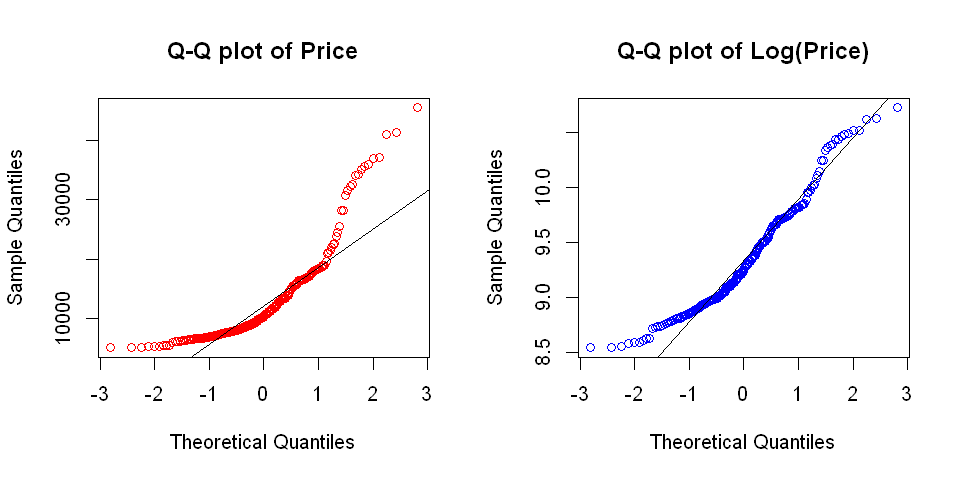

In [4]:
# Normality Testing of Price and log(Price)
price <- auto.data$price
price.log <- log(price)

# Graphical test using qqplot:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow = c(1, 2))
qqnorm(price, main ='Q-Q plot of Price',col="red");qqline(price)
qqnorm(price.log, main = 'Q-Q plot of Log(Price)',col="blue");qqline(price.log)
par(mfrow = c(1, 1))
# Neither looks particularly normal. log(Price) may be somewhat more normal.
# This makes some sense in that there are very few cars cheaper than some minimum number.

# Formal Test using Shapiro-Wilk
shapiro.test(price)
shapiro.test(price.log)

# Yes, log(price) is much closer to normal than price - although still not particularly normal.
# So use that instead.
auto.data$price <- log(auto.data$price)

Based on both the quantile plots and the S-W test results (p <=0.05 in both cases), log(price) is much closer to normal than price - although still not particularly normal. So use that instead.

I will use log(Price) for the subsequent calculations.

## Significance of Log(Price) relative to Fuel Type, Aspiration, and front vs. rear wheel drive


	Welch Two Sample t-test

data:  auto.gas and auto.diesel
t = -1.9795, df = 23.73, p-value = 0.05947
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.466760568  0.009882369
sample estimates:
mean of x mean of y 
 9.328981  9.557420 


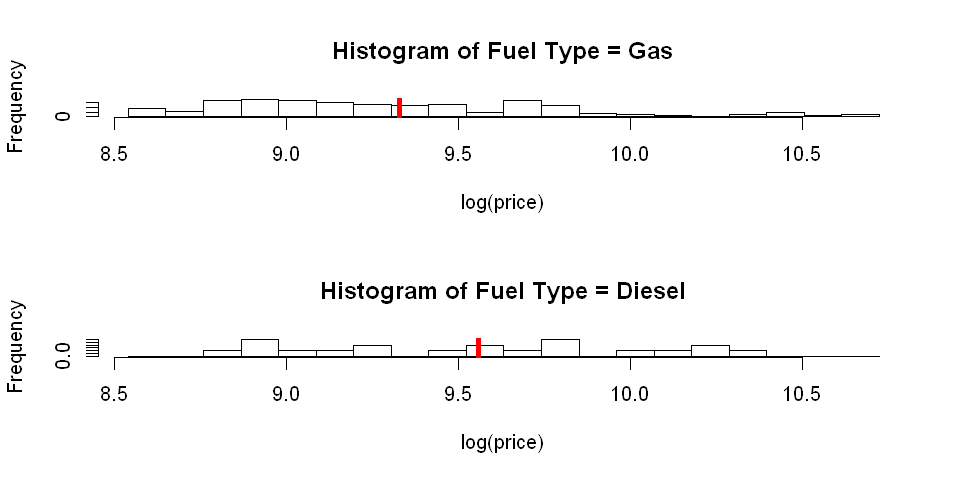

In [5]:
auto.gas=data.matrix(select(filter(auto.data, fuel.type =='gas'),price))
auto.diesel=data.matrix(select(filter(auto.data, fuel.type =='diesel'),price))
plot.t(auto.gas, auto.diesel, 'log(price)','Fuel Type = Gas','Fuel Type = Diesel')
t.test(auto.gas,auto.diesel, alternative = "two.sided")

Based on the p value, we cannot reject the hypothesis that the means are different at a 95% confidence level.

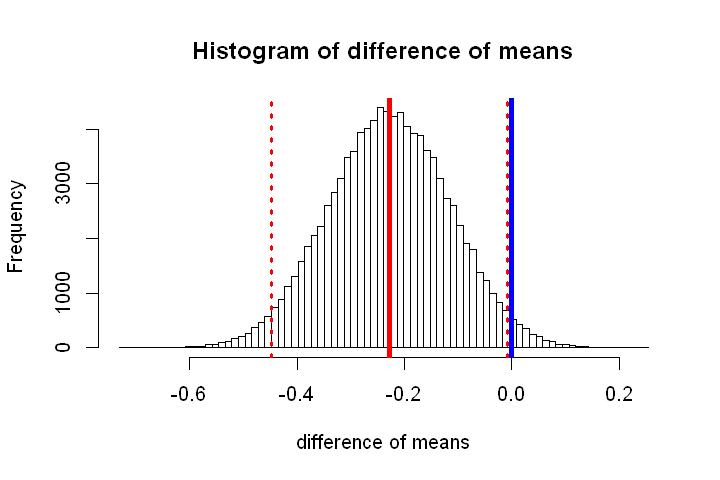

In [7]:
options(repr.plot.width=6, repr.plot.height=4)
two.boot.mean = two.boot(auto.gas, auto.diesel, mean, R = 100000)
plot.diff(two.boot.mean$t)

In this case, the bootstrapped difference of means is just on the edge of significance.


	Welch Two Sample t-test

data:  auto.std and auto.turbo
t = -4.4432, df = 65.419, p-value = 3.501e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4848426 -0.1841688
sample estimates:
mean of x mean of y 
 9.291426  9.625932 


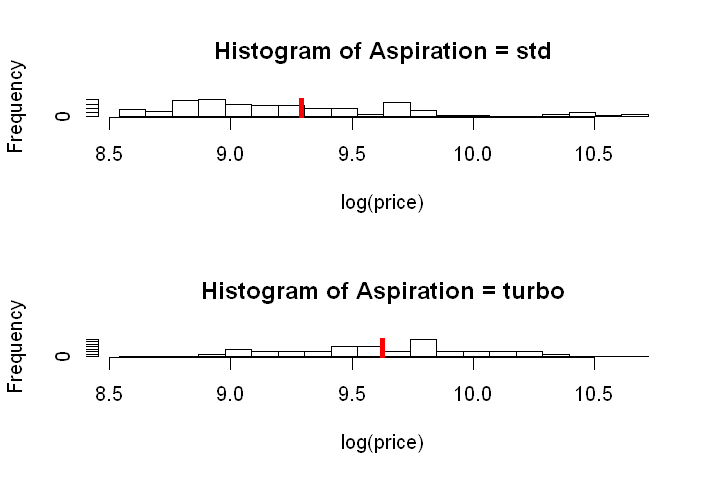

In [8]:
auto.std=data.matrix(select(filter(auto.data, aspiration =='std'),price))
auto.turbo=data.matrix(select(filter(auto.data, aspiration =='turbo'),price))
plot.t(auto.std, auto.turbo, 'log(price)','Aspiration = std','Aspiration = turbo')
t.test(auto.std,auto.turbo, alternative = "two.sided")

Based on the small P value, we can conclude that the alternative hypothesis, that the means are different, is true.

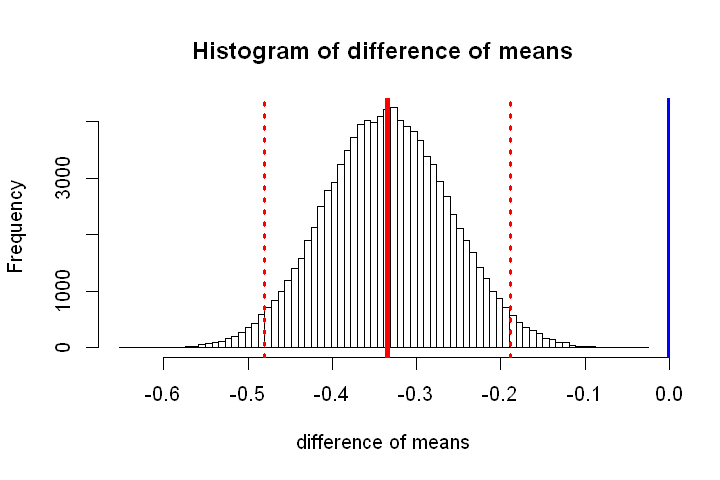

In [10]:
options(repr.plot.width=6, repr.plot.height=4)
two.boot.mean = two.boot(auto.std, auto.turbo, mean, R = 100000)
plot.diff(two.boot.mean$t)

Bootstrapping aspiration type strentghens the conclusion that turbo is significantly different than std aspiration, since the 95% CI of the difference of means falls outside of zero.

##Analysis of variance for number of doors and body style

In [11]:
###
# ANOVA - Doors
###

numdoors.count <- data.frame(count(auto.data,num.of.doors))
numdoors.count


num.of.doors,n
?,2
four,112
two,85


There are 2 entries with bad data - discard

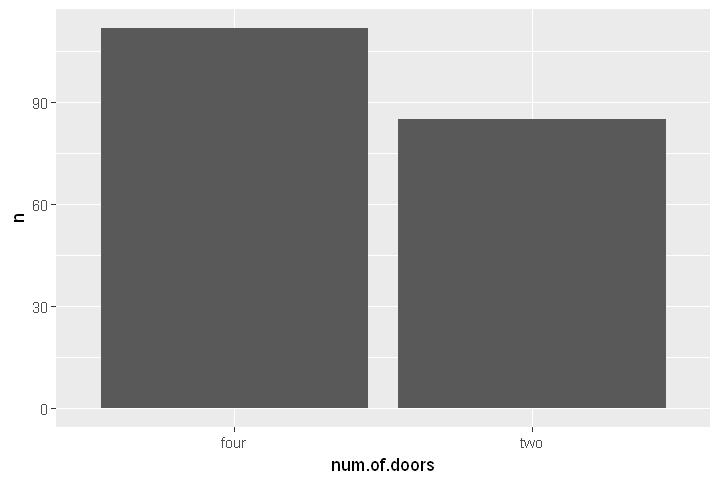

In [12]:
numdoors.count <- subset (numdoors.count, num.of.doors!='?')
ggplot(numdoors.count,aes(x=num.of.doors, y=n))+geom_bar(stat='identity')


Plenty of data in both categories!

Call:
   aov(formula = val ~ group, data = df)

Terms:
                   group Residuals
Sum of Squares   0.53271  49.75671
Deg. of Freedom        1       195

Residual standard error: 0.5051362
Estimated effects may be unbalanced


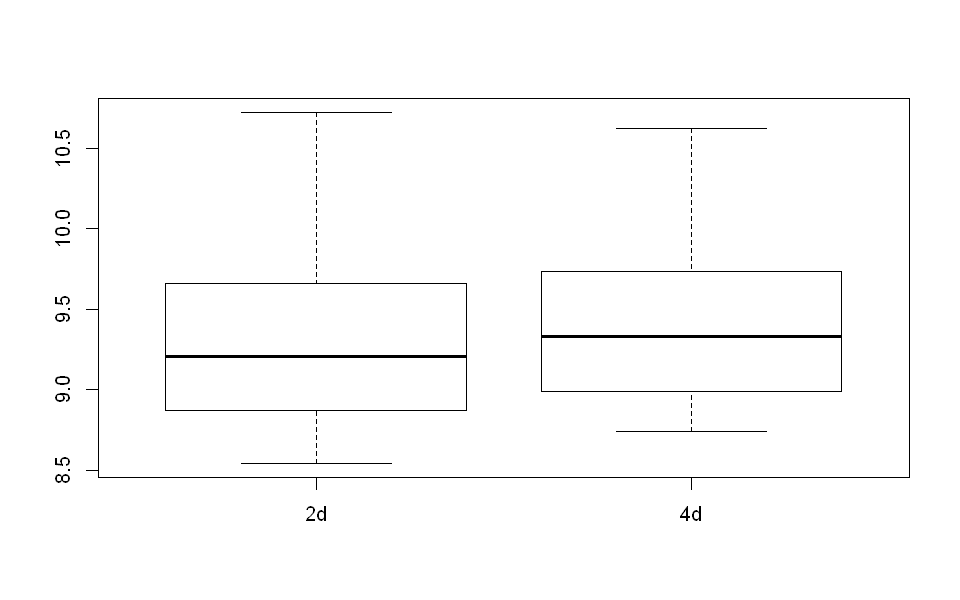

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = val ~ group, data = df)

$group
           diff         lwr       upr     p adj
4d-2d 0.1049931 -0.03831638 0.2483026 0.1500911



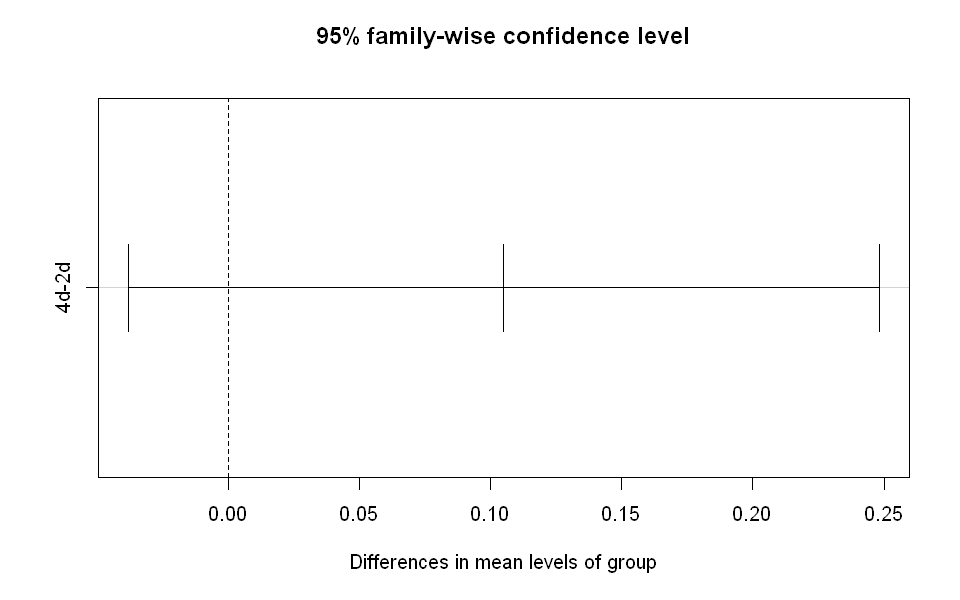

In [13]:
auto.2d=filter(auto.data, num.of.doors == 'two')
auto.4d=filter(auto.data, num.of.doors == 'four')

df.door <- data.frame('group'=c(rep('2d',length(auto.2d$price)),
                           rep('4d',length(auto.4d$price))),
                 'val' = c(auto.2d$price,auto.4d$price))

ANOVA.plot(df.door)

Visually they look similar, and the Tukey test implies that we cannot reject the null hypothesis that they are the same.

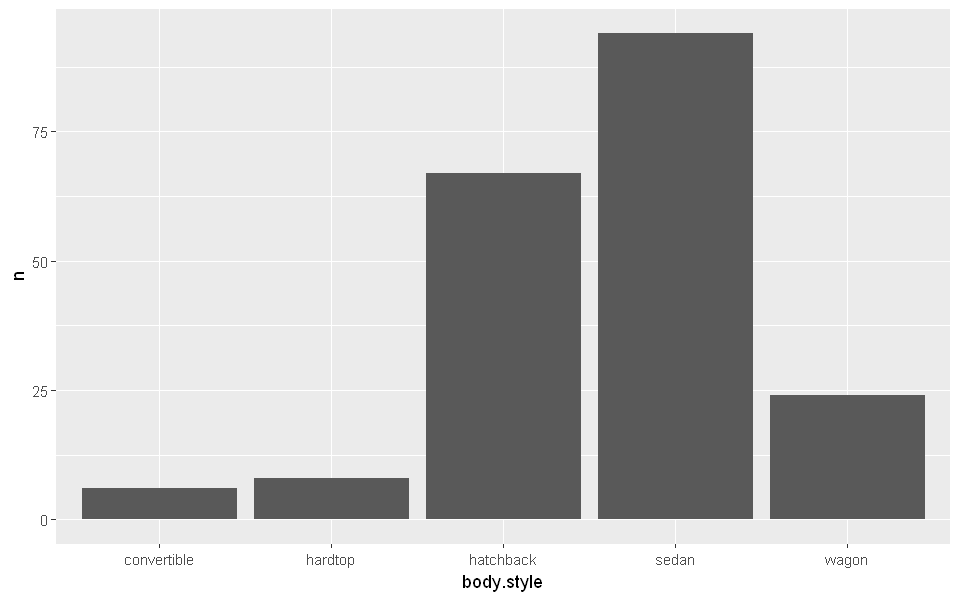

In [14]:
###
# ANOVA - Body Type
###

body.count <- data.frame(count(auto.data,body.style))
ggplot(body.count,aes(x=body.style, y=n))+geom_bar(stat='identity')
# Hmm, convertibles and hardtops don't have much data - discard from ANOVA

Call:
   aov(formula = val ~ group, data = df)

Terms:
                   group Residuals
Sum of Squares   3.86079  38.16534
Deg. of Freedom        2       182

Residual standard error: 0.4579297
Estimated effects may be unbalanced


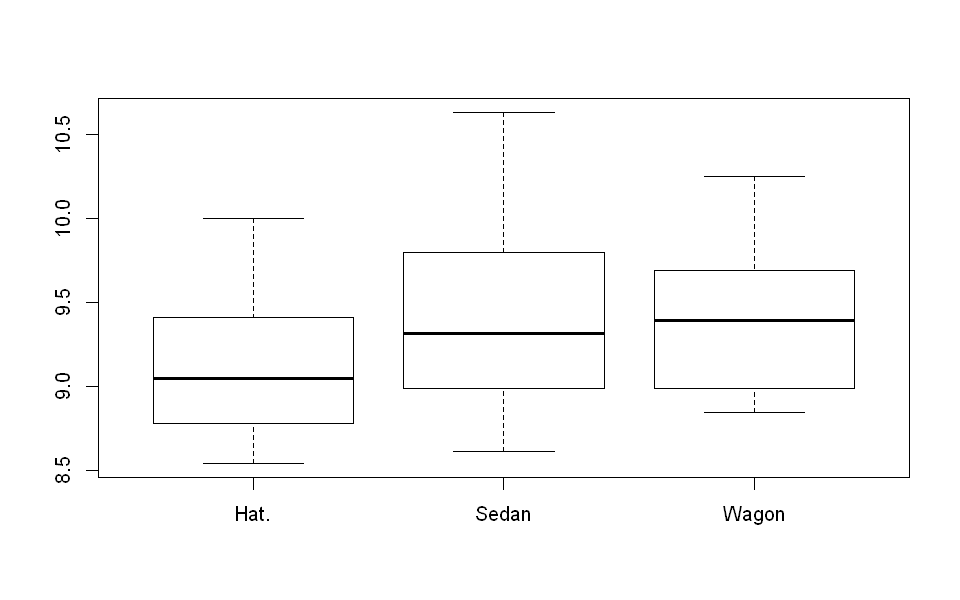

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = val ~ group, data = df)

$group
                  diff         lwr       upr     p adj
Sedan-Hat.   0.3119639  0.13894922 0.4849786 0.0000964
Wagon-Hat.   0.2328792 -0.02454479 0.4903032 0.0851511
Wagon-Sedan -0.0790847 -0.32656622 0.1683968 0.7309131



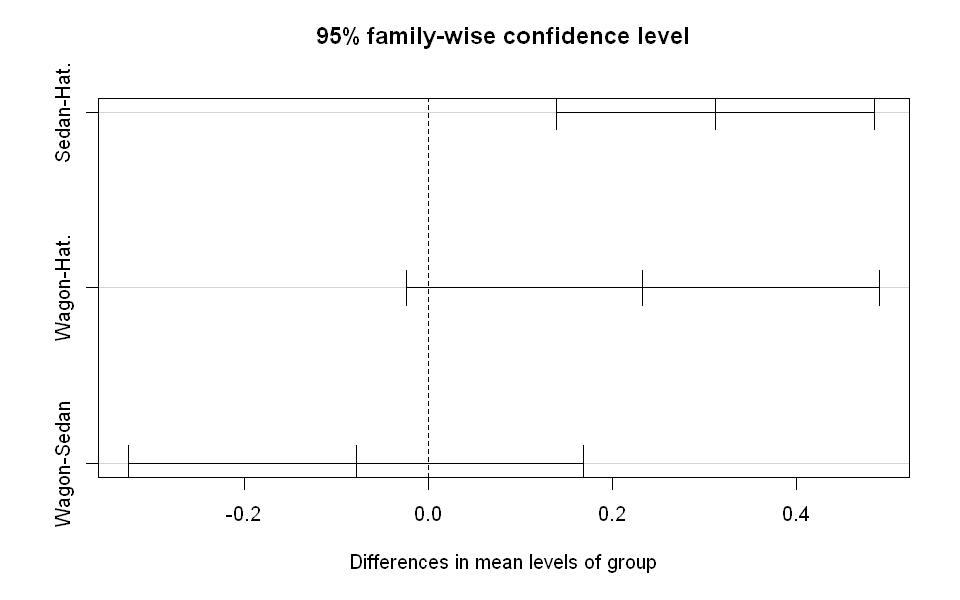

In [15]:
auto.hat=filter(auto.data, body.style == 'hatchback')
auto.sed=filter(auto.data, body.style == 'sedan')
auto.wag=filter(auto.data, body.style == 'wagon')

df.body <- data.frame('group'=c(rep('Hat.',length(auto.hat$price)),
                           rep('Sedan',length(auto.sed$price)),
                           rep('Wagon',length(auto.wag$price))),
                 'val' = c(auto.hat$price,auto.sed$price,auto.wag$price))

ANOVA.plot(df.body)

Based on the Tukey coefficients, there is not a significant price difference between wagons and sedans, but there is for both wagons and hatchbacks and hatchbacks vs. sedans.

Now try resampling these also:

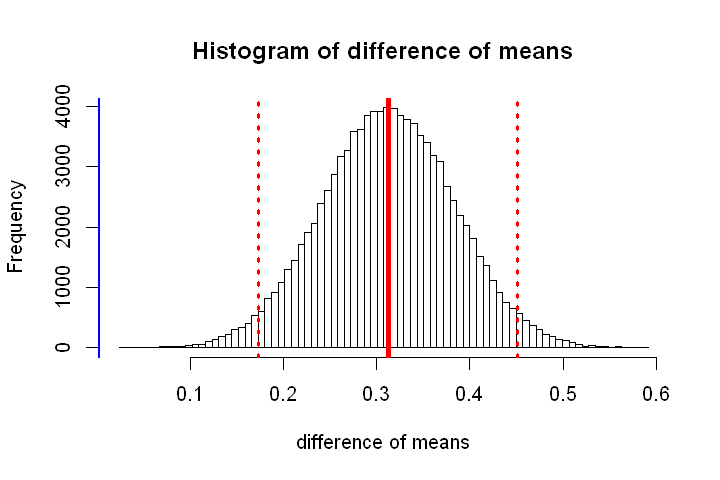

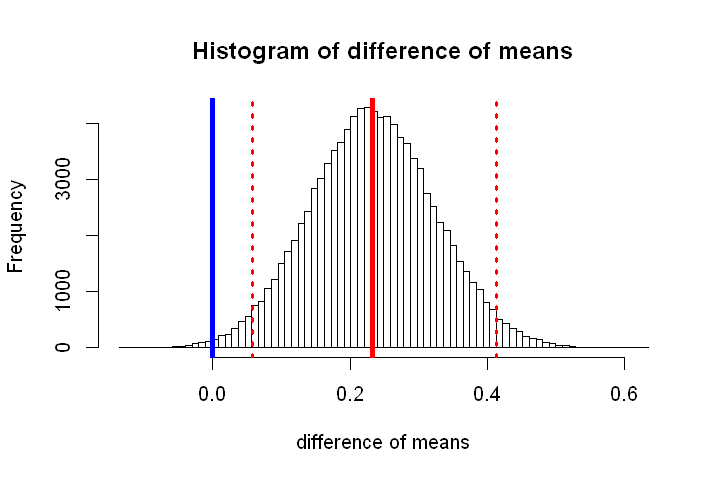

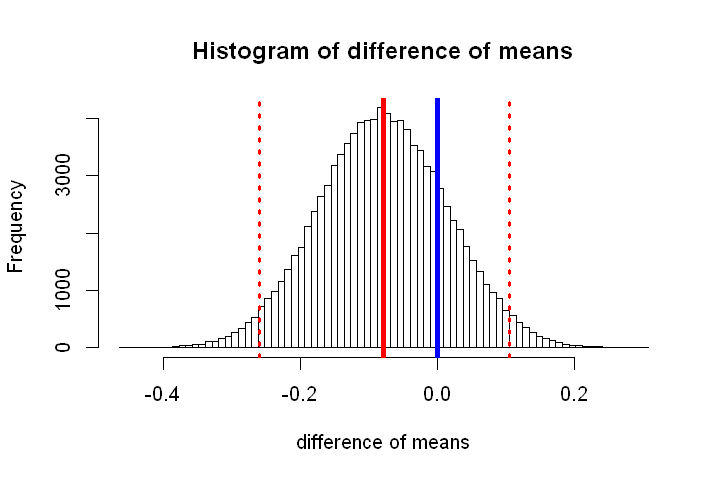

In [16]:
## Now plot resampled differences of means by pairs:

options(repr.plot.width=6, repr.plot.height=4)
two.boot.mean = two.boot(auto.sed$price,auto.hat$price, mean, R = 100000)
plot.diff(two.boot.mean$t)

options(repr.plot.width=6, repr.plot.height=4)
two.boot.mean = two.boot(auto.wag$price,auto.hat$price, mean, R = 100000)
plot.diff(two.boot.mean$t)

options(repr.plot.width=6, repr.plot.height=4)
two.boot.mean = two.boot(auto.wag$price,auto.sed$price, mean, R = 100000)
plot.diff(two.boot.mean$t)